In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System, OptimizerType, plot_loss_df

In [2]:
# try to fit the initial guess
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 5000})
pde_model.set_state(["e"], {"e": [0., 1.]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "ae": .11,
    "ah": .07,
    "kappa": 2,
})
sys1 = System([Constraint("e", Comparator.LT, "0.3", label="smaller")], "sys1")
sys1.add_endog_equation("q=1.05+.06/.3*e")
sys1.add_endog_equation("psi = 1/.3*e")
sys2 = System([Constraint("e", Comparator.GEQ, "0.3", label="smaller")], "sys2")
sys2.add_endog_equation("q=1.1 - .03/.7*e")
sys2.add_endog_equation("psi = 1")
pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/1Dtest/pymacrofin_1d_init.pt"):
    pde_model.train_model("./models/1Dtest", "pymacrofin_1d_init.pt", True)
    pde_model.load_model(torch.load("./models/1Dtest/pymacrofin_1d_init_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/1Dtest/pymacrofin_1d_init_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "AdamW"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "ae": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: q
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, ou

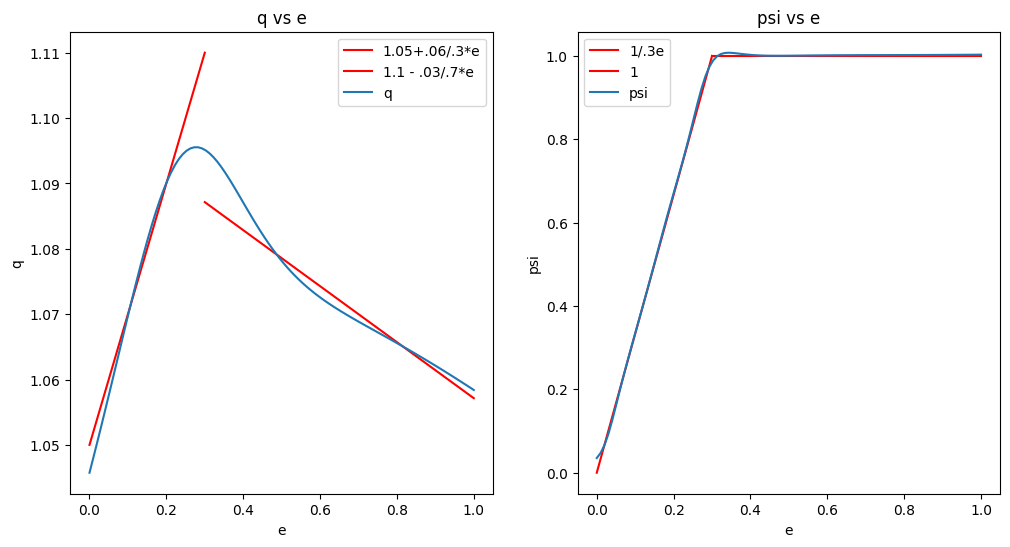

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
e = np.linspace(0, 1)
e1 = np.linspace(0, 0.3)
e2 = np.linspace(0.3, 1)
ax[0].plot(e1, 1.05+0.06/0.3*e1, label="1.05+.06/.3*e", color="red")
ax[0].plot(e2, 1.1 - .03/.7*e2, label="1.1 - .03/.7*e", color="red")
ax[1].plot(e1, 1/.3*e1, label="1/.3e", color="red")
ax[1].plot(e2, np.ones_like(e2), label="1", color="red")
# ax[2].plot(x, (-4 + 8 * x) * np.exp(-2*x), label="(-4+8x)e^{-2x}")
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

In [4]:
pde_model = PDEModel("BruSan14_log_utility", {"num_epochs": 100, "loss_log_interval": 10})
pde_model.set_state(["e"], {"e": [0., 1.0]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "ae": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_endog_condition("psi", 
                              "psi(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min")
pde_model.add_equation("iota = (q**2-1)/(2*kappa)")
# the following eqution and endogenous equations can only be calculated in R if psi>e
sys = System([Constraint("psi", Comparator.GT, "e", "activation_const")], "act_sys")
sys.add_equation("sigq = (((ae-ah)/q+deltah-deltae)/(psi/e-(1-psi)/(1-e)))**0.5 - sig")
sys.add_endog_equation("q*(r*(1-e)+rho*e) - psi*ae - (1-psi)*ah + iota=0")
sys.add_endog_equation("(psi-e)*q_e - q*(1-sig/(sig+sigq))=0")
pde_model.add_system(sys)

print(pde_model)
pde_model.load_model(torch.load("./models/1Dtest/pymacrofin_1d_init_best.pt"))
pde_model.train_model("./models/1Dtest", "pymacrofin_1d2.pt", True)
pde_model.load_model(torch.load("./models/1Dtest/pymacrofin_1d2_best.pt"))
pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 0.001,
 "loss_log_interval": 10,
 "optimizer_type": "AdamW"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "ae": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: q
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_

Total loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 91.01it/s]

training finished, total time :: 1.1189656257629395
Best model saved to ./models/1Dtest/pymacrofin_1d2_best.pt if valid
Model saved to ./models/1Dtest/pymacrofin_1d2.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0028,
endogvar_psi_cond_psi_min: 0.0013,
system_act_sys: 0.1003,
total_loss: 0.1044


OrderedDict([('endogvar_q_cond_q_min',
              tensor(0.0028, grad_fn=<MeanBackward0>)),
             ('endogvar_psi_cond_psi_min',
              tensor(0.0013, grad_fn=<MeanBackward0>)),
             ('system_act_sys', tensor(0.1003, grad_fn=<AddBackward0>)),
             ('total_loss', tensor(0.1044, grad_fn=<AddBackward0>))])

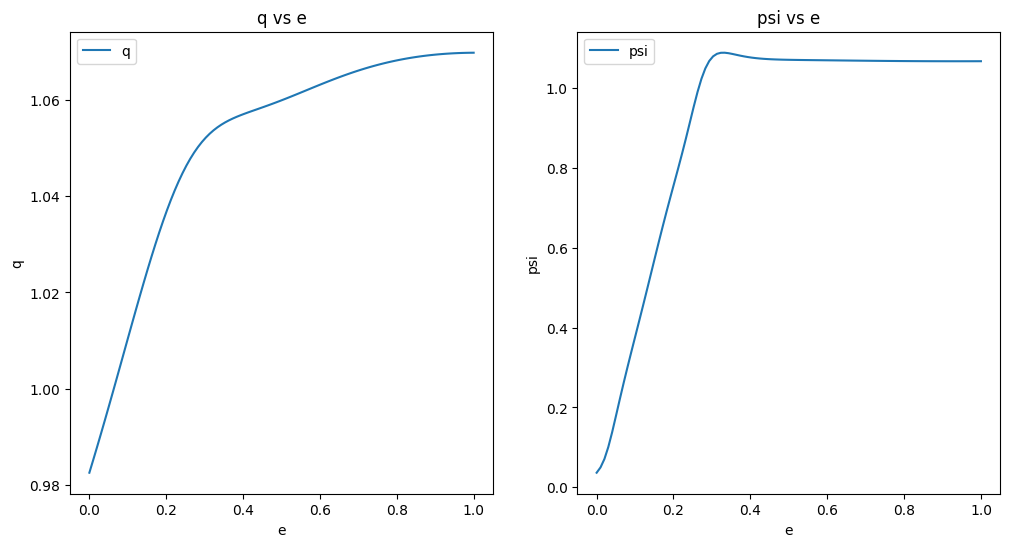

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
e = np.linspace(0, 1)
# ax[0].plot(x, (1 + 2 * x) * np.exp(-2*x), label="(1+2x)e^{-2x}")
# ax[1].plot(x, -4 * x * np.exp(-2*x), label="-4xe^{-2x}")
# ax[2].plot(x, (-4 + 8 * x) * np.exp(-2*x), label="(-4+8x)e^{-2x}")
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

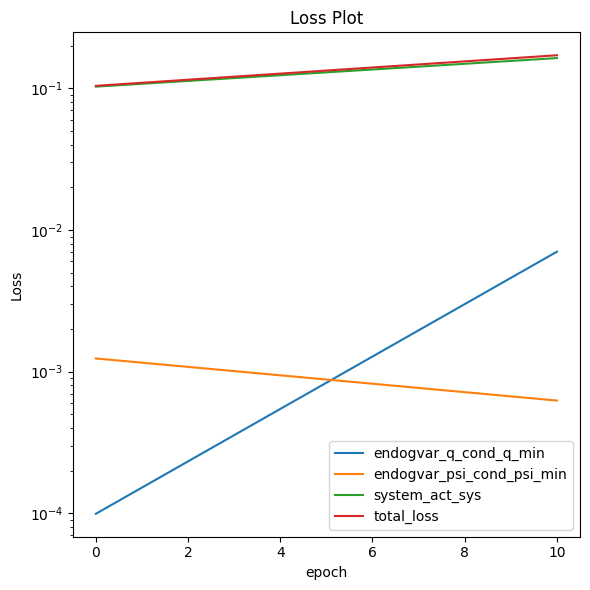

In [6]:
plot_loss_df(fn="./models/1Dtest/pymacrofin_1d2_loss.csv", loss_plot_fn="./models/1Dtest/pymacrofin_1d2_loss.jpg")